In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#Link to Data:
#https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

In [2]:
%matplotlib inline
import cv2
import os
import math
import copy

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
import torchvision
import random
from os import listdir
from os.path import isfile, join
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# import skimage
from skimage.io import imread

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

torch.manual_seed(0)


In [4]:
def createDirectory(dirname):
    try:
        os.mkdir(dirname)
    except FileExistsError:
        print("Directory " + dirname + " already exists.")

In [5]:
models_dir = "models/"
createDirectory(models_dir)

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
model = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


In [8]:
for layer, param in model.named_parameters():
    
    if 'layer4' not in layer:
        param.requires_grad = False

from torch import nn
fc_inputs = model.fc.in_features
 
model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(fc_inputs, 2),
    torch.nn.LogSoftmax(dim=1)
)

In [9]:
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
    ])

In [10]:
root_path='/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/'
dirtr='train/'
dirvl='val/'

In [11]:
dataset = datasets.ImageFolder(root=root_path + dirtr, transform=train_transforms)


In [12]:
from torchvision import datasets
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 32

#random_seed= 42
targets = dataset.targets

# stratified split for validation
train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets)
train_sampler =SubsetRandomSampler(train_idx)
valid_sampler =SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=2)
validloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=2)

In [13]:
p=[]
s0=0
length=0
for i,l in trainloader:
    p=p+l.tolist()
traindf=pd.DataFrame(p,columns=['traintarget'])

In [14]:
p1=[]
s0=0
length=0
for i,l in validloader:
    p1=p1+l.tolist()
validdf=pd.DataFrame(p1,columns=['validtarget'])

In [15]:
data=pd.DataFrame(dataset.targets,columns=['datatargets'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6eb4fb5bd0>]],
      dtype=object)

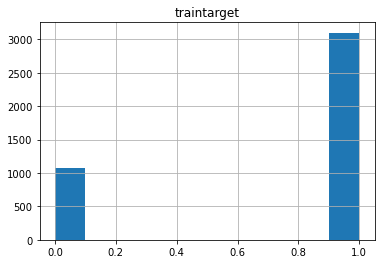

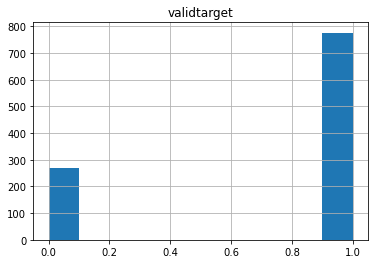

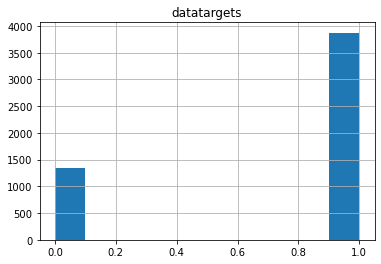

In [16]:
traindf.hist()
validdf.hist()
data.hist()

In [17]:
LEARNING_RATE = 0.001
#we give more weights to the Class 0 because the data is umbalanced
weights = [1, 0.25]
class_weights = torch.FloatTensor(weights).cuda()

criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [18]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
total_epoch = 20

best_epoch = 0
training_losses = []
val_losses = []


for epoch in range(total_epoch):
    
    epoch_train_loss = 0
    pred=[]
    target=[]
    
    for X, y in trainloader:
        
        X, y = X.cuda(), y.cuda()
        
        optimizer.zero_grad()
        result = model(X)
        loss = criterion(result, y)
        epoch_train_loss += loss.item()
        loss.backward()
        optimizer.step()
      
    training_losses.append(epoch_train_loss)
    
    
    epoch_val_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for X, y in validloader:
            
            X, y = X.cuda(), y.cuda()
             
            result = model(X)
            loss = criterion(result, y)
            epoch_val_loss += loss.item()
            
            
        
            _, maximum = torch.max(result.data, 1)
            maximum=maximum.tolist()
            y=y.tolist()
            pred = pred+maximum
            target = target+y
            #total += y.size(0)
            #correct += (maximum == y).sum().item()
            
    val_losses.append(epoch_val_loss)
    
    import numpy as np
    from sklearn.metrics import roc_auc_score

    pred = np.vstack((pred)).ravel()
    auc = roc_auc_score(target, pred)
    
    #accuracy = correct/total
    print("EPOCH:", epoch, ", Training Loss:", epoch_train_loss, ", Validation Loss:", epoch_val_loss, ", AUC: ", auc)
    
    
    if min(val_losses) == val_losses[-1]:
        best_epoch = epoch
        checkpoint = {'model': model,
                            'state_dict': model.state_dict(),
                            'optimizer' : optimizer.state_dict()}

        torch.save(checkpoint, models_dir + '{}.pth'.format(epoch))
        print("Model saved")

EPOCH: 0 , Training Loss: 17.713047261349857 , Validation Loss: 1.8267004997469485 , AUC:  0.981449069087552
Model saved
EPOCH: 1 , Training Loss: 6.202769644296495 , Validation Loss: 1.6628599412506446 , AUC:  0.9789390675488537
Model saved
EPOCH: 2 , Training Loss: 2.888634570495924 , Validation Loss: 1.8612510126840789 , AUC:  0.9837186490229266
EPOCH: 3 , Training Loss: 2.794055950380425 , Validation Loss: 2.3194694763078587 , AUC:  0.97869864594553
EPOCH: 4 , Training Loss: 6.540913908771472 , Validation Loss: 1.8444372458034195 , AUC:  0.9743229727650408
EPOCH: 5 , Training Loss: 1.2672627264546463 , Validation Loss: 0.5826485004945425 , AUC:  0.9904696876442529
Model saved
EPOCH: 6 , Training Loss: 0.4500946156349528 , Validation Loss: 0.895841027179813 , AUC:  0.9898926757962764
EPOCH: 7 , Training Loss: 0.28606712140134505 , Validation Loss: 1.4878979115601396 , AUC:  0.9897580396984151
EPOCH: 8 , Training Loss: 0.12796703664622555 , Validation Loss: 1.0143735238416411 , AUC: 

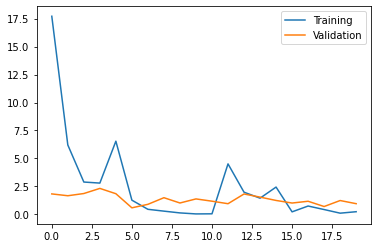

In [20]:
plt.plot(range(total_epoch), training_losses, label='Training')
plt.plot(range(total_epoch), val_losses, label='Validation')
plt.legend()

In [21]:
models_dir = "models/"

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False
    
    return model.eval()


filepath = models_dir + str(best_epoch) + ".pth"
loaded_model = load_checkpoint(filepath)

train_transforms = transforms.Compose([
                                       transforms.Resize((224,224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
                                       ])

In [22]:
dirtest='test/'
test = datasets.ImageFolder(root=root_path + dirtest, transform=train_transforms)

test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle = True)

# test loader

In [23]:
correct = 0
total = 0
pred=[]   
target=[]
predmax=[]
with torch.no_grad():
    for X, y in test_loader:

        X, y = X.cuda(), y.cuda()

        result = loaded_model(X)
        _, maximum = torch.max(result.data, 1)
        maximum=maximum.tolist()
        predmax = predmax+maximum
        
        res= result[:,1]
        res=res.tolist()
        y=y.tolist()
        pred = pred+res
        target = target+y
pred = np.vstack((pred)).ravel()
auc = roc_auc_score(target, pred)
print(auc)





0.9322813938198553


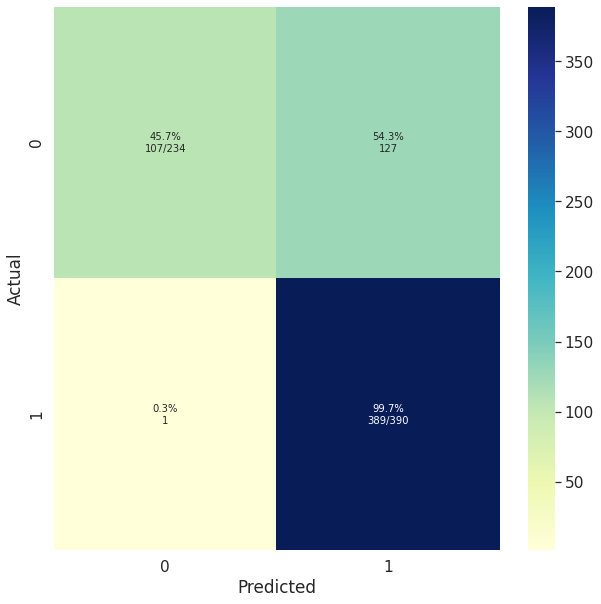

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(target, predmax)

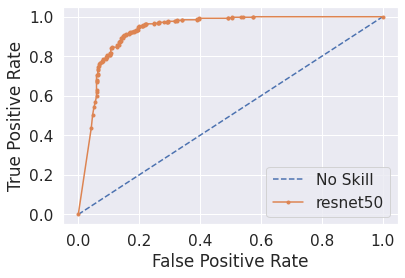

In [37]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot

fpr, tpr, thresholds = roc_curve(target, pred)
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='resnet50')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [38]:
# calculate the g-mean for each threshold
from numpy import sqrt
from numpy import argmax
gmeans = sqrt(tpr * (1-fpr))

In [39]:
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=-0.000332, G-Mean=0.878


Best Threshold=-0.000332, G-Mean=0.878


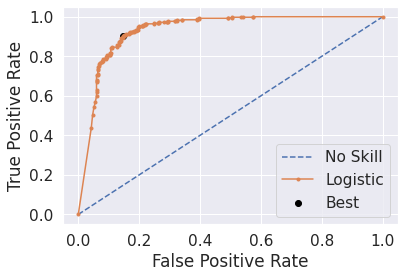

In [40]:
fpr, tpr, thresholds = roc_curve(target, pred)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
pyplot.plot(fpr, tpr, marker='.', label='Logistic')
pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
# show the plot
pyplot.show()

In [41]:
labs=[]
for i in pred:
    if i < -0.000332 : 
        labs.append(0)
    else:
        labs.append(1)

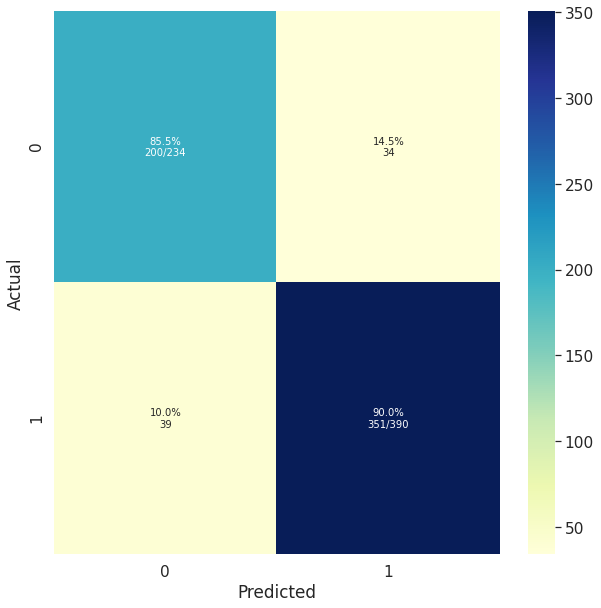

In [46]:
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_cm(y_true, y_pred, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    
plot_cm(target, labs)

In [47]:
from sklearn.metrics import classification_report
print(classification_report(target, labs))

              precision    recall  f1-score   support

           0       0.84      0.85      0.85       234
           1       0.91      0.90      0.91       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.88      0.88      0.88       624



In [48]:
from sklearn.metrics import classification_report
print(classification_report(target, predmax))

              precision    recall  f1-score   support

           0       0.99      0.46      0.63       234
           1       0.75      1.00      0.86       390

    accuracy                           0.79       624
   macro avg       0.87      0.73      0.74       624
weighted avg       0.84      0.79      0.77       624

